# BNS 4 param example


# Agenda

1. Carry out Parameter estimation on a binary neutron star system
1. Stochastically sample the posterior distribution using `bilby`.


## Notes
1. BNS signals are longer (by a factor of 10, low masses)
1. More intelligent sampling necessary (nestle)

# Parameter estimation
1. Inject a BNS singal into a detector
1. Analze using bilby and nestle.

## Fixed parameters

1. Extrinsic
    1. Polarization angle `psi`,
    1. Sky location `ra`, `dec`,
    1. Signal's arrival time at geocenter `geocent_time`,
    1. Orbital / coalescence `phase`,
    1. Inclination angle `theta_jn`
    1. Luminosity distance `luminosity_distance`
1. Intrinsic
    1. Spin components `a_1`, `a_2`, `tilt_1`, `tilt_2`, `phi_12`, `phi_jl`
    1. Tidal deformabilities `lambda_1`, `lambda_2`

##  To sample over
1. Intrinsic:
    1. Component masses `m_1`, `m_2` in terms of `symmetric_mass_ratio`, `chirp_mass`
    \begin{equation}
     \eta = \dfrac{m_1 m_2}{(m_1 + m_2)^2} \qquad,\,\, \mathcal{M} = \dfrac{(m_1 * m_2)^{3/5}}{(m_1 + m_2)^{1/5}}
    \end{equation}
## Priors
1. Uniform in (component masses)
1. Uniform in comoving volume prior on luminosity distance (100Mpc, 5Gpc)

## Collab setup

In [1]:
!pip install pycbc lalsuite bilby nestle matplotlib

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.9/73.9 kB 2.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 45.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 7.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 82.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.9/983.

## PC setup

### Using anaconda/miniconda
`conda env create -f environment.yaml`

`conda activate np3m`

OR

### Using pip
Create a python virtual environment and
`pip install -r requirements.txt`

In [2]:
import bilby
from bilby.core.utils.random import seed

# Sets seed of bilby's generator "rng" to "123" to ensure reproducibility
seed(123)

# Specify the output directory and the name of the simulation.
outdir = "bns_outdir"
label = "bns_4parama"
bilby.core.utils.setup_logger(outdir=outdir, label=label)

## Injection parameters

In [3]:

# We are going to inject a binary neutron star waveform.  We first establish a
# dictionary of parameters that includes all of the different waveform
# parameters, including masses of the two black holes (mass_1, mass_2),
# aligned spins of both black holes (chi_1, chi_2), etc.
injection_parameters = dict(
    mass_1=1.5,
    mass_2=1.3,
    chi_1=0.02,
    chi_2=0.02,
    luminosity_distance=50.0,
    theta_jn=0.4,
    psi=2.659,
    phase=1.3,
    geocent_time=1126259642.413,
    ra=1.375,
    dec=-1.2108,
    lambda_1=545,
    lambda_2=1346,
    fiducial=1
)

all_injection_parameters = bilby.gw.conversion.generate_all_bns_parameters(injection_parameters)

## Data sampling parameters

In [4]:

# Set the duration and sampling frequency of the data segment that we're going
# to inject the signal into. For the
# TaylorF2 waveform, we cut the signal close to the isco frequency
duration = 32
sampling_frequency = 2048
start_time = injection_parameters["geocent_time"] + 2 - duration

# Waveform generator

In [5]:

# Fixed arguments passed into the source model. The analysis starts at 40 Hz.
waveform_arguments = dict(
    waveform_approximant="IMRPhenomPv2_NRTidal",
    reference_frequency=50.0,
    minimum_frequency=40.0,
)

# Create the waveform_generator using a LAL Binary Neutron Star source function
waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_neutron_star,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters,
    waveform_arguments=waveform_arguments,
)

12:12 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters


## Inject the signal into the detector

In [6]:

# Set up interferometers.  In this case we'll use three interferometers
# (LIGO-Hanford (H1), LIGO-Livingston (L1), and Virgo (V1)).
# These default to their design sensitivity and start at 40 Hz.
interferometers = bilby.gw.detector.InterferometerList(["H1", "L1", "V1"])
for interferometer in interferometers:
    interferometer.minimum_frequency = 40
interferometers.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency, duration=duration, start_time=start_time
)
interferometers.inject_signal(
    parameters=injection_parameters, waveform_generator=waveform_generator
)

/home/vaishakprasad/soft/anaconda/envs/igwn-py310/lib/python3.10/site-packages/bilby/gw/source.py:528: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal
12:12 bilby INFO    : Injected signal in H1:
12:12 bilby INFO    :   optimal SNR = 34.44
12:12 bilby INFO    :   matched filter SNR = 33.89-0.55j
12:12 bilby INFO    :   mass_1 = 1.5
12:12 bilby INFO    :   mass_2 = 1.3
12:12 bilby INFO    :   chi_1 = 0.02
12:12 bilby INFO    :   chi_2 = 0.02
12:12 bilby INFO    :  

[{'plus': array([ 0.00000000e+00-0.00000000e+00j,  0.00000000e+00-0.00000000e+00j,
          0.00000000e+00-0.00000000e+00j, ...,
         -4.23008636e-25+7.98210938e-26j, -4.23011798e-25+7.97089719e-26j,
          0.00000000e+00-0.00000000e+00j]),
  'cross': array([0.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j, ...,
         7.95519924e-26+4.21582544e-25j, 7.94402485e-26+4.21585695e-25j,
         0.00000000e+00+0.00000000e+00j])},
 {'plus': array([ 0.00000000e+00-0.00000000e+00j,  0.00000000e+00-0.00000000e+00j,
          0.00000000e+00-0.00000000e+00j, ...,
         -4.23008636e-25+7.98210938e-26j, -4.23011798e-25+7.97089719e-26j,
          0.00000000e+00-0.00000000e+00j]),
  'cross': array([0.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j, ...,
         7.95519924e-26+4.21582544e-25j, 7.94402485e-26+4.21585695e-25j,
         0.00000000e+00+0.00000000e+00j])},
 {'plus': ar

## Define the priors

In [7]:

# Load the default prior for binary neutron stars.
# We're going to sample in chirp_mass, symmetric_mass_ratio, lambda_tilde, and
# delta_lambda_tilde rather than mass_1, mass_2, lambda_1, and lambda_2.
# BNS have aligned spins by default, if you want to allow precessing spins
# pass aligned_spin=False to the BNSPriorDict
priors = bilby.gw.prior.BNSPriorDict()
for key in [
    "psi",
    "geocent_time",
    "ra",
    "dec",
    "chi_1",
    "chi_2",
    "theta_jn",
    "luminosity_distance",
    "phase",
#    "lambda_1",
#    'lambda_2'
]:
    priors[key] = injection_parameters[key]

del priors["mass_ratio"], priors["lambda_1"], priors["lambda_2"]
priors["chirp_mass"] = bilby.core.prior.Gaussian(
    1.215, 0.1, name="chirp_mass", unit="$M_{\\odot}$"
)
priors["symmetric_mass_ratio"] = bilby.core.prior.Uniform(
    0.1, 0.25, name="symmetric_mass_ratio"
)
priors["lambda_tilde"] = bilby.core.prior.Uniform(0, 5000, name="lambda_tilde")
priors["delta_lambda_tilde"] = bilby.core.prior.Uniform(
    -500, 1000, name="delta_lambda_tilde"
)
priors["lambda_1"] = bilby.core.prior.Constraint(
    name="lambda_1", minimum=0, maximum=10000
)
priors["lambda_2"] = bilby.core.prior.Constraint(
    name="lambda_2", minimum=0, maximum=10000
)

12:12 bilby INFO    : No prior given, using default BNS priors in /home/vaishakprasad/soft/anaconda/envs/igwn-py310/lib/python3.10/site-packages/bilby/gw/prior_files/aligned_spins_bns_tides_on.prior.


In [8]:
priors

{'mass_1': Constraint(minimum=0.5, maximum=5, name='mass_1', latex_label='$m_1$', unit=None),
 'mass_2': Constraint(minimum=0.5, maximum=5, name='mass_2', latex_label='$m_2$', unit=None),
 'chirp_mass': Gaussian(mu=1.215, sigma=0.1, name='chirp_mass', latex_label='$\\mathcal{M}$', unit='$M_{\\odot}$', boundary=None),
 'luminosity_distance': 50.0,
 'dec': -1.2108,
 'ra': 1.375,
 'theta_jn': 0.4,
 'psi': 2.659,
 'phase': 1.3,
 'chi_1': 0.02,
 'chi_2': 0.02,
 'geocent_time': 1126259642.413,
 'symmetric_mass_ratio': Uniform(minimum=0.1, maximum=0.25, name='symmetric_mass_ratio', latex_label='$\\eta$', unit=None, boundary=None),
 'lambda_tilde': Uniform(minimum=0, maximum=5000, name='lambda_tilde', latex_label='$\\tilde{\\Lambda}$', unit=None, boundary=None),
 'delta_lambda_tilde': Uniform(minimum=-500, maximum=1000, name='delta_lambda_tilde', latex_label='$\\delta\\tilde{\\Lambda}$', unit=None, boundary=None),
 'lambda_1': Constraint(minimum=0, maximum=10000, name='lambda_1', latex_label='

## Initialize the likelihood

In [9]:
# Initialise the likelihood by passing in the interferometer data (IFOs)
# and the waveform generator
likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    interferometers=interferometers,
    waveform_generator=waveform_generator,
)

# Run sampler.  In this case we're going to use the `nestle` sampler
result = bilby.run_sampler(
    likelihood=likelihood,
    priors=priors,
    sampler="nestle",
    npoints=100,
    injection_parameters=injection_parameters,
    outdir=outdir,
    label=label,
    conversion_function=bilby.gw.conversion.generate_all_bns_parameters,
    result_class=bilby.gw.result.CBCResult,
    #bound='multi'
)

12:12 bilby INFO    : Running for label 'bns_4parama', output will be saved to 'bns_outdir'
12:12 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
12:12 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
12:12 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
12:12 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
12:12 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
12:12 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
12:12 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
12:12 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
12:12 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
12:12 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundanc

it=  2493 logz=1388.116466500000052504760255204420248704468581108159154915854115511802457988908195786371375080447864043704443832883878176942523235360430575644792184786706982848387200926575803737830233794788090059368953234970799945081119038967640880074652742780142494579258788820056842838115669472196386865459400540160.000000


12:16 bilby INFO    : Sampling time: 0:04:02.388039
12:16 bilby INFO    : Computing per-detector log likelihoods.


  0%|          | 0/2594 [00:00<?, ?it/s]

12:16 bilby INFO    : Generating sky frame parameters.


  0%|          | 0/2594 [00:00<?, ?it/s]

12:16 bilby INFO    : Computing SNRs for every sample.


  0%|          | 0/2594 [00:00<?, ?it/s]

12:17 bilby INFO    : Summary of results:
nsamples: 2594
ln_noise_evidence: -95975.554
ln_evidence: -94587.069 +/-  0.477
ln_bayes_factor: 1388.485 +/-  0.477



In [10]:
all_injection_parameters = bilby.gw.conversion.generate_all_bns_parameters(injection_parameters)

In [11]:
result.posterior

,chirp_mass,symmetric_mass_ratio,lambda_tilde,delta_lambda_tilde,luminosity_distance,dec,ra,theta_jn,psi,phase,...,chi_eff,chi_1_in_plane,chi_2_in_plane,chi_p,redshift,comoving_distance,mass_1_source,mass_2_source,chirp_mass_source,total_mass_source
0,1.215040,0.248792,856.614878,314.500565,50.0,-1.2108,1.375,0.4,2.659,1.3,...,0.02,0.0,0.0,0.0,0.011202,49.446114,1.480492,1.288048,1.201580,2.768540
1,1.215079,0.248708,873.717058,230.389672,50.0,-1.2108,1.375,0.4,2.659,1.3,...,0.02,0.0,0.0,0.0,0.011202,49.446114,1.484118,1.285070,1.201619,2.769188
2,1.215089,0.249110,860.139304,358.748430,50.0,-1.2108,1.375,0.4,2.659,1.3,...,0.02,0.0,0.0,0.0,0.011202,49.446114,1.465784,1.300744,1.201628,2.766528
3,1.214971,0.248427,871.185738,175.477314,50.0,-1.2108,1.375,0.4,2.659,1.3,...,0.02,0.0,0.0,0.0,0.011202,49.446114,1.495294,1.275527,1.201512,2.770822
4,1.215047,0.248811,858.254852,101.278016,50.0,-1.2108,1.375,0.4,2.659,1.3,...,0.02,0.0,0.0,0.0,0.011202,49.446114,1.479695,1.288738,1.201587,2.768432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2589,1.215044,0.248752,869.682576,-163.466733,50.0,-1.2108,1.375,0.4,2.659,1.3,...,0.02,0.0,0.0,0.0,0.011202,49.446114,1.482226,1.286591,1.201584,2.768817
2590,1.215044,0.248752,869.682576,-163.466733,50.0,-1.2108,1.375,0.4,2.659,1.3,...,0.02,0.0,0.0,0.0,0.011202,49.446114,1.482226,1.286591,1.201584,2.768817
2591,1.215044,0.248752,869.682576,-163.466733,50.0,-1.2108,1.375,0.4,2.659,1.3,...,0.02,0.0,0.0,0.0,0.011202,49.446114,1.482226,1.286591,1.201584,2.768817
2592,1.215044,0.248752,869.682576,-163.466733,50.0,-1.2108,1.375,0.4,2.659,1.3,...,0.02,0.0,0.0,0.0,0.011202,49.446114,1.482226,1.286591,1.201584,2.768817


In [12]:
truths = {}

#for key in ["chirp_mass", "symmetric_mass_ratio"]:
for key in ["chirp_mass", "symmetric_mass_ratio", "lambda_tilde"]:
#for key in ["chirp_mass"]:
    truths.update({key : all_injection_parameters[key]})

In [13]:
truths

{'chirp_mass': 1.2150360414642816,
 'symmetric_mass_ratio': 0.24872448979591844,
 'lambda_tilde': 867.9931562541493}

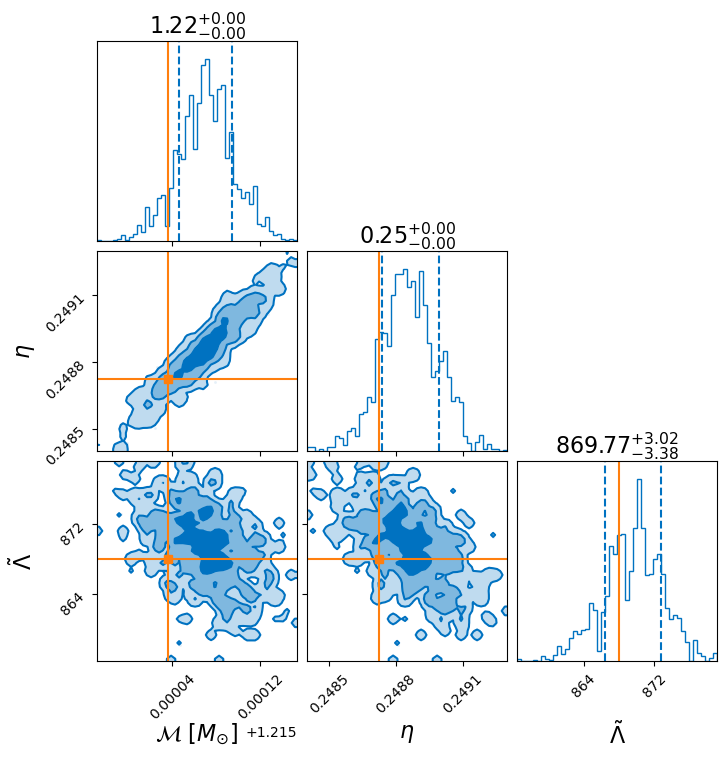

In [14]:
result.plot_corner(truths=truths)